# Project: Epidemics in the air

## Introduction

In the project work, your task is to implement a Susceptible-Infected (SI) disease spreading model and run it on top of a temporal network from air transport data, containing information on the departure and arrival times of flights. You will study the dynamics of spreading and how it depends on where the process starts as well as the infectivity of the disease, and use static-network centrality measures to understand the roles that specific nodes play.

To get you started, you may use this notebook or the Python template `project.py` available in MyCourses. **Using the notebook or template is fully optional.** If using the notebook or template, you only need to fill in the required functions. Some of the functions do **not** need modifications. You may start your solution after the subtitle "**Begin of the Exercise**" down below. 

In addition to returning a short report of your results (including the visualizations), return also your commented Python code or notebook (all code related to the project as a **zip** file). **Always label the axes in your figures!** When reporting your results, remember to answer all questions asked in the exercise sheet available in MyCourses. Please note that this notebook contains only the programming tasks of the project, not the questions about interpreting the results.

## Model specifications

In the SI model, each node is either Susceptible (S) or Infected (I). When an Infected node is in contact with a Susceptible node, the Susceptible node may become infected with some probability _p ∈_ [0, 1], reflecting the infectivity of the disease. Infected nodes remain Infected forever.

In our model that mimics the spreading of disease through the air transport network, nodes are airports and time-stamped connections are flights between them. Initially, only one airport node (called the seed node) is set to the Infected state, while all other airports are Susceptible. Now, following the SI process, a flight from an Infected source airport infects its Susceptible destination airport with probability _p ∈_ [0, 1]. Note that a flight can carry the infection only if its source airport is infected at the time of the flight’s departure! Infected airports remain infected for the rest of the simulation.

## Data description

The data that are used in the project are available at `/coursedata/project`. You can also download the data from the course MyCourses page as a `.zip` file. 

The flight data that you will use to perform your simulation are located in the file `events_US_air_traffic_GMT.txt`, where each row contains the following fields:

<pre>
1st column -> Source [0-278]
2nd column -> Destination [0-278]
3rd column -> Start Time (GMT) [seconds after Unix epoch time]
4th column -> End Time (GMT)
5th column -> Duration [Same as (EndTime-StartTime)]
</pre>

The aggregated weighted network `aggregated_US_air_traffic_network_undir.edg` is constructed based on the event data, so that the weight of each link corresponds to the number of flights between the nodes. This network is static and undirected. Additionally, you can find the information about the airports in file `US_airport_id_info.csv`. `US_air_bg.png` is an image of the USA map used as a background image in some visualizations.

In [1]:
import networkx as nx
import numpy as np
from numpy import random
import pandas as pd
import pickle
import time
import os

from matplotlib import pyplot as plt
from matplotlib import rc
rc.usetex = True
from matplotlib.animation import FuncAnimation
import scipy.stats

# Data

Let us load the data from the right folder and specify paths of files used in the project. If you run this notebook on your own computer, please specify the right folder.

In [2]:
# Select data directory
if os.path.isdir('/coursedata/project'):
    project_data_dir = '/coursedata/project'
elif os.path.isdir('../data/project'):
    project_data_dir = '../data/project'
else:
    # Specify course_data_dir on your machine
    project_data_dir = 'some_path'

event_file_path = project_data_dir + '/events_US_air_traffic_GMT.txt'
network_file_path = project_data_dir + '/aggregated_US_air_traffic_network_undir.edg'
airport_info_file_path = project_data_dir + '/US_airport_id_info.csv'
background_image_file_path = project_data_dir + '/US_air_bg.png'

print('The data directory is %s' % project_data_dir)
print('The event file is at %s' % event_file_path)
print('The aggregated network file is at %s' % network_file_path)
print('The airport info file is at %s' % airport_info_file_path)
print('The visualization background image is at %s' % background_image_file_path)

The data directory is /coursedata/project
The event file is at /coursedata/project/events_US_air_traffic_GMT.txt
The aggregated network file is at /coursedata/project/aggregated_US_air_traffic_network_undir.edg
The airport info file is at /coursedata/project/US_airport_id_info.csv
The visualization background image is at /coursedata/project/US_air_bg.png


## Visualization tools

The following visualization tools are provided to help you. There is no need to modify these parts.

The frunction `plot_prevalence` is used in multiple tasks from Task 2 onwards and `plot_scatters_in_subplots` from Task 4 onwards. The function `plot_network_USA` is used in Task 6. 

As an extra visualization, you can find a function called `visualize_si` which animates the air transport using `matplotlib`. The animations use the background image `US_air_bg.png`, the airport id-info file `US_airport_id_info.csv` and the events file `events_US_air_traffic_GMT.txt`, all of which are available at `/coursedata/project`. Note that this visualization is not needed for completion of the tasks, it’s just offered for your benefit.

In [3]:
def plot_prevalence(prevalence_data, time_bins, colors, labels):
    """
    Plots the prevalence of the disease (proportion of infected
    nodes) as a function of time.
    
    Parameters:
    -----------
    prevalence_data : np.array
        the data to be plotted. Each row of prevalence_data is
        plotted as a separate plot. Number of columns should
        match the length of time_bins
    time_bins : np.array
        time bins used to calculate the prevalence. prevalence_data[N][i]
        should contain the proportion of nodes infected before time_bins[i]
        (in condition N)
    colors : list
        colors of the lines to be plotted. len(colors) should match the
        number of rows in prevalence_data
    labels : list
        labels of the lines to be plotted. len(labels) should match the
        number of rows in prevalence_data
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    time_bins = time_bins - time_bins[0] # origin shift: all times are now expressed as "after time_bins[0]"
    
    for prevalence, color, label in zip(prevalence_data, colors, labels):
        ax.plot(time_bins, prevalence, color = color, label = label)

    ax.legend(loc="best")
    ax.set_xlabel("Time in seconds after first event.")
    ax.grid()
    ax.set_ylabel("Prevalence of the disease")

In [4]:
def plot_scatters_in_subplots(x_vals, y_vals, labels, n_columns=2, y_label='Infection time', x_labels=[]):
    """
    Creates a set of scatter plots, each of them located in
    a subplot of its own.
    
    Parameters:
    -----------
    x_vals : list
        x values of the scatter plots (e.g. values of network properties to be plotted); y_vals[i]
        should be a list of y values of type i for all nodes
    y_vals: iterable
        y values of the scatter plots (e.g. median infection times); y_vals will be
        separately plotted against all elements of x_vals
    labels : list
        labels of the scatter points to be plotted. len(labels) should match the
        number of elements in x_vals.
    n_columns : int
        how many columns should the final figure contain, i.e. how many
        subplots there should be at each row
    y_label : str
        label of the y axis
    x_labels : list
        labels of the x axes for each subplot (given as strings); 
        if given, len(x_labels) should match the number of elements
        in x_vals.
    """
    fig = plt.figure()
    
    n_subplots = len(x_vals)
    n_rows = n_subplots / np.float(np.ceil(n_columns))
    
    if len(x_labels) == 0:
        x_labels = labels
    
    for i, (x_val, label, x_label) in enumerate(zip(x_vals, labels, x_labels)):
        ax = fig.add_subplot(n_rows, n_columns, i + 1)
        ax.scatter(x_val, y_vals, label=label, alpha=0.2)
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.legend(loc="best")
    fig.tight_layout()

In [5]:
def plot_network_usa(net, xycoords, bg_figname, edges=None, linewidths=None):
    """
    Plots the network on top of the USA map.
    This code makes use of the file US_air_bg.png available at /coursedata.
    If you want to use this function outside of Jupyterhub, the file
    should be located in the same directory where you run the code.

    Parameters
    ----------
    net : nx.Graph()
        the network to be plotted
    xycoords : dict
        dictionary of node_id to coordinates (x,y)
    bg_figname: str
        path of the background image used in the visualization (string); 
        in this project, the path of US_air_bg.png
    edges : list 
        a list of node index tuples (node_i,node_j),
        if None all network edges are plotted.
    linewidths : list
        a list with equal length and order to egdes -list.
        See nx.draw_networkx documentation

    example code:

    import random
    import pandas as pd
    import numpy as np
    import networkx as nx

    id_data = np.genfromtxt(csv_path, delimiter=',', dtype=None, names=True)
    xycoords = {}
    for row in id_data:
        xycoords[str(row['id'])] = (row['xcoordviz'], row['ycoordviz'])
    net = nx.read_weighted_edgelist(network_path)

    lw_list =[]
    edgelist =[]
    for edge in net.edges():
        lw_list.append(random.random()) # change this at least
        edgelist.append(edge) # edgelist created to maintain the right order
    
    plot_network_usa(net, xycoords, bg_fname, edges=edgelist, linewidths=lw_list)

    """
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 0.9])
    img = plt.imread(bg_figname)
    axis_extent = (-6674391.856090588, 4922626.076444283,
                   -2028869.260519173, 4658558.416671531)
    ax.imshow(img, extent=axis_extent)
    ax.set_xlim((axis_extent[0], axis_extent[1]))
    ax.set_ylim((axis_extent[2], axis_extent[3]))
    ax.set_axis_off()
    nx.draw_networkx_nodes(net,
                     pos=xycoords,
                     node_color='k',
                     node_size=5,
                     alpha=0.2)
    if edges is None:
        edges = net.edges()
    
    if linewidths is None:
        linewidths = np.ones(len(edges))

    for edge, lw  in zip(edges, linewidths):
        nx.draw_networkx_edges(
            net,
            pos=xycoords,
            edge_color='r',
            width=lw,
            edgelist=[edge],
            alpha=lw,
        )
    return fig, ax

In [6]:
class SI_AnimHelper(object):
    """
    A class used for creating animated visualizations of the epidemic. 
    For a function making use of this class, see visualize_si below.
    """
    def __init__(self, infection_times, event_fname, airport_info_csv_name, bg_figname):
        if not os.path.exists(event_fname):
            raise IOError("File " + event_fname + "could not be found")

        self.ed = np.genfromtxt(
            event_fname,
            delimiter=' ',
            dtype=None,
            names=True
        )

        self.infection_times = infection_times

        if not os.path.exists(airport_info_csv_name):
            raise IOError("File " + event_fname + "could not be found")

        id_data = np.genfromtxt(
            airport_info_csv_name,
            delimiter=',',
            dtype=None,
            names=True
        )
        self.xcoords = id_data['xcoordviz']
        self.ycoords = id_data['ycoordviz']
        self.fig = plt.figure(figsize=(10, 10))
        self.ax = self.fig.add_axes([0, 0, 1, 1])
        img = plt.imread(bg_figname)
        self.axis_extent = (-6674391.856090588, 4922626.076444283,
                            -2028869.260519173, 4658558.416671531)
        self.img = self.ax.imshow(img, extent=self.axis_extent)
        self.ax.set_xlim((self.axis_extent[0], self.axis_extent[1]))
        self.ax.set_ylim((self.axis_extent[2], self.axis_extent[3]))
        self.ax.set_axis_off()
        self.time_text = self.ax.text(
            0.1, 0.1, "", transform=self.ax.transAxes)
        self.scat_planes = self.ax.scatter([], [], s=0.2, color="k")

        self.n = len(self.xcoords)
        self.airport_colors = np.array(
            [[0, 1, 0] for i in range(self.n)], dtype=float)
        self.scat_airports = self.ax.scatter(
            self.xcoords, self.ycoords, c=self.airport_colors, s=5, alpha=0.2)

    def draw(self, frame_time):
        """
        Draws the current situation of the epidemic spreading.

        Parameters
        ----------
        frame_time : int
            the current time in seconds
            (should lie somewhere between 1229231100 and 1230128400)
        """
        time_str = time.asctime(time.gmtime(frame_time))
        self.time_text.set_text(time_str)
        # this should be improved
        unfinished_events = (self.ed['EndTime'] > frame_time)
        started_events = (self.ed['StartTime'] < frame_time)

        # oge = 'on going events'
        oge = self.ed[started_events * unfinished_events]
        fracs_passed = (float(frame_time) - oge['StartTime']) / oge['Duration']
        ongoing_xcoords = ((1 - fracs_passed) * self.xcoords[oge['Source']]
                           + fracs_passed * self.xcoords[oge['Destination']])
        ongoing_ycoords = ((1 - fracs_passed) * self.ycoords[oge['Source']]
                           + fracs_passed * self.ycoords[oge['Destination']])
        self.scat_planes.set_offsets(
            np.array([ongoing_xcoords, ongoing_ycoords]).T)
        self.event_durations = self.ed['Duration']

        infected = (self.infection_times < frame_time)

        self.airport_colors[infected] = (1, 0, 0)  # red
        self.airport_colors[~infected] = (0, 1, 1)  # green
        self.scat_airports = self.ax.scatter(
            self.xcoords, self.ycoords, c=self.airport_colors, s=20, alpha=0.5)

    def draw_anim(self, frame_time):
        self.draw(frame_time)
        return self.time_text, self.scat_planes, self.scat_airports

    def init(self):
        return self.time_text, self.scat_planes, self.scat_airports

In [7]:
def visualize_si(infection_times,
                 event_fname,
                 airport_info_csv_name,
                 bg_figname,
                 viz_start_time=1229231100,
                 viz_end_time=1230128400,
                 tot_viz_time_in_seconds=60,
                 fps=10,
                 save_fname=None,
                 writer=None):
    """
    Animates the infection process as a function of time.

    Parameters
    ----------
    infection_times : numpy array
        infection times of the nodes
    event_fname : str
        path of the event file
    airport_info_csv_name : str
        path of the airport info file
    viz_start_time : int
        start time in seconds after epoch
    viz_end_time : int
        end_time in seconds after epoch
    tot_viz_time_in_seconds : int
        length of the animation for the viewer
    fps : int
        frames per second (use low values on slow computers)
    save_fname : str
        where to save the animation
    """
    print(airport_info_csv_name)

    # By default, spans the whole time range of infections.
    times = np.linspace(
        viz_start_time, viz_end_time, fps * tot_viz_time_in_seconds + 1)
    siah = SI_AnimHelper(infection_times,event_fname, airport_info_csv_name, bg_figname)
    ani = FuncAnimation(
        siah.fig, siah.draw_anim, init_func=siah.init, frames=times,
        interval=1000 / fps, blit=True
    )
    if save_fname is not None:
        print("Saving the animation can take quite a while.")

        print("Be patient...")

        ani.save(save_fname, writer='ffmpeg', codec='mpeg4')
    else:
        plt.show()

## Begin of the Exercise

### Task 1: Basic implementation

Implement the SI model using the temporal air traffic data in `events_US_air_traffic_GMT.txt`. Use the provided visualization module to check that your implementation works reasonably. Assume first that _p_ = 1, i.e., the disease is always transmitted.

If Allentown (node-id=0) is infected at the beginning of the data set, at which time
does Anchorage (ANC, node-id=41) become infected? \
_Hint:_ The time point should fall within the range `1229290000–1229291000`.

In [8]:
def get_net_and_id_data(network_file_path,airport_info_file_path):
    """
    Reads the network and airport information.
    
    Parameters
    ----------
    network_file_path : str
            path of the network file
    airport_info_file_path : str
            path of the airport info csv file
            
    Returns
    -------
    net : nx.Graph
            the weighted network read from the file
    id_data : pd.DataFrame
            information about airport id's, symbols, names, and cities
    """
    # YOUR CODE HERE
    net = nx.read_weighted_edgelist(network_file_path)
    id_data = pd.read_csv(airport_info_file_path, index_col='id')
    #TODO: implement a function for reading the network and airport info
    # Hint: make use of pd_read_csv for reading the airport info
    return net, id_data

In [9]:
def simulate_si(infection_prob, event_file_path, airport_info_file_path,
                seed=None, immunized_nodes=[], return_trans_nodes=False):
    """
    General function for simulating the SI dynamics.

    Parameters
    ----------
    infection_prob : float
        the probability of infection per flight
    event_file_path : str
        path of the event file
    airport_info_file_path : str
        path of the airport info file
    seed : int
        the seed node index
    immunized_nodes : list
        indexes of nodes that have been immunized (used in task 5)
    return_trans_nodes : bool
        if True, the indices of the source nodes of disease-transmitting 
        flights are returned (used in task 6)
        
    Returns:
    --------
    infection_times : list or np.array
        time when each of the nodes gets infected, infection time of 
        non-infected nodes is Inf
    seed : int
        index of the seed node used
    trans_nodes : list or np.array
        the origin of infection (i.e. the source of the infection-carrying
        flight) for each node
    
    """
    infection_times = []
    trans_nodes = []
    # YOUR CODE HERE
    flights = pd.read_csv(event_file_path, sep=' ')
    flights = flights.sort_values(by=['StartTime', 'EndTime'], ascending=[True, True])
    flights = flights.reset_index(drop=True)
    
    airport_data = pd.read_csv(airport_info_file_path, index_col='id')
    
    infection_times = [np.float('inf') for _ in airport_data.iterrows()]
    infection_times[seed] = flights['StartTime'].min()
    
    trans_nodes = [None for _ in airport_data.iterrows()]
    trans_nodes[seed] = seed
    
    for flight in flights.iterrows():
        source, destinition, s_time, e_time, duration = flight[1]
        if (infection_times[source] <= s_time):
            if (infection_times[destinition] > e_time) and (np.random.rand() <= infection_prob) and destinition not in immunized_nodes:
                infection_times[destinition] = e_time
                trans_nodes[destinition] = source
            
    #TODO: implement a function for running the SI simulation
    # Hints: 
    
    # Use infection_times to keep a record of the infection times of airports (it can be either a list
    # or an np.array). infection_times[i] should be the infection time of node i at all times. Initially, 
    # set the infection times of all nodes to np.float('inf'), excluding the seed node (you can set the 
    # data set’s first flight’s departure time as the infection time for the seed). Then, whenever a node becomes
    # infected, set its time of infection to the arrival time of the flight carrying the infection.
    
    # To implement the model, first sort all flights in increasing order of departure time, and then go through 
    # them in sequence. Is the source node infected at the current time (look this up in infection_times)? If so,
    # check if the infection time of the target node is larger that the arrival time of the flight. If so, the 
    # flight infects the target node with probability p. In this case, set the target node's infection time to
    # the flight's arrival time.
    
    # pd.read_csv is handy for reading the event and airport data.

    # You can use iterrows() from pandas to loop over flights.
    
    if return_trans_nodes:
        return infection_times, seed, trans_nodes
    return infection_times, seed

In [10]:
p = 1.0
_, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

id_seed = 0
target_seed = 0

# YOUR CODE HERE
id_target = 41
# TODO: add the seed and target node indices

inf_times, _ = simulate_si(p, event_file_path, 
                           airport_info_file_path, seed=id_seed)

print( "Infected node:\n", id_data.loc[id_seed])

#target_infection_time = int(inf_times[id_target[0][0]])
target_infection_time = int(inf_times[id_target])

print ("--------------------\n\n Target node: ")
print (id_data.loc[id_target])
print ("infected at time " + str(target_infection_time) + "\n")

Infected node:
 symbol                         ABE
airport name    Lehigh Valley Intl
city                     Allentown
latitude                   40.6521
longitude                 -75.4408
xcoordviz              1.92609e+06
ycoordviz                   337358
Name: 0, dtype: object
--------------------

 Target node: 
symbol                                 ANC
airport name    Ted Stevens Anchorage Intl
city                             Anchorage
latitude                           61.1744
longitude                         -149.996
xcoordviz                     -2.84493e+06
ycoordviz                      3.25767e+06
Name: 41, dtype: object
infected at time 1229290800



### Task 2: Effect of infection probability p on spreading speed

Run the SI model 10 times with each of the infection probabilities [0.01, 0.05, 0.1, 0.5, 1.0]. Again, let Allentown (node-id=0) be the initially infected node. Record all infection times of the nodes. 

Plot the averaged prevalence _ρ(t)_ of the disease (fraction of infected nodes) as a function of time for each of the infection probabilities. Plot the 5 curves in one graph. You should be able to spot stepwise, nearly periodic plateaus in the curves.

In [11]:
def get_time_bins(event_file_path, n_time_bins):
    """
    Reads from the event file the flight departure and
    arrival times and divided the time from the first departure
    to the last arrival into n_time_bins slots.
    
    Parameters:
    -----------
    event_file_path : str
        path of the event file
    n_time_bins : int
        number of time bins
        
    Returns:
    --------
    time_bins : np.array
        the time bins used for calculating prevalence
    """
    time_bins = []
    # YOUR CODE HERE
    flights = pd.read_csv(event_file_path, sep=' ')
    first_dep = flights['StartTime'].min()
    last_arrv = flights['EndTime'].max()
    
    time_bins = np.linspace(first_dep, last_arrv, n_time_bins)
    #TODO: write a function for getting the time bins
    #Hint: make use of np.linspace
    
    return time_bins

In [12]:
def calculate_prevalence(infection_times, time_bins):
    """
    Calculates the prevalence of the infection 
    (i.e. fraction of infected nodes) as a function
    of time. Prevalence is calculated in linear time bins,
    so that prevalence of each bin is the fraction of nodes
    infected before the bin.
    
    Parameters:
    -----------
    infection_times : list or np.array
        time when each of the nodes gets infected, infection time of 
        non-infected nodes is Inf
    n_time_bins : int
        number of time bins
        
    Returns:
    --------
    prevalence : np.array
        prevalence (i.e. fraction of infected nodes) in each time bin
    """
    prevalence = []      
    
    # YOUR CODE HERE
    n_airports = len(infection_times)
    for time_step in time_bins:
        infected = [airport for airport, infected_time in enumerate(infection_times) if infected_time <= time_step]
        prevalence.append(len(infected)/n_airports)
    #TODO: write a function for calculating prevalence as a function of time
    # Hint: to get the prevalence, count the number of nodes infected before each time step step and normalize by 
    # the total number of nodes.
    
    prevalence = np.array(prevalence)
    
    return prevalence

-----Calculating with Probabiliy=0.01-----
Iteration 1/10: Running SI Model with p=0.01.
Iteration 2/10: Running SI Model with p=0.01.
Iteration 3/10: Running SI Model with p=0.01.
Iteration 4/10: Running SI Model with p=0.01.
Iteration 5/10: Running SI Model with p=0.01.
Iteration 6/10: Running SI Model with p=0.01.
Iteration 7/10: Running SI Model with p=0.01.
Iteration 8/10: Running SI Model with p=0.01.
Iteration 9/10: Running SI Model with p=0.01.
Iteration 10/10: Running SI Model with p=0.01.
------------------DONE!------------------
-----Calculating with Probabiliy=0.05-----
Iteration 1/10: Running SI Model with p=0.05.
Iteration 2/10: Running SI Model with p=0.05.
Iteration 3/10: Running SI Model with p=0.05.
Iteration 4/10: Running SI Model with p=0.05.
Iteration 5/10: Running SI Model with p=0.05.
Iteration 6/10: Running SI Model with p=0.05.
Iteration 7/10: Running SI Model with p=0.05.
Iteration 8/10: Running SI Model with p=0.05.
Iteration 9/10: Running SI Model with p=0.0

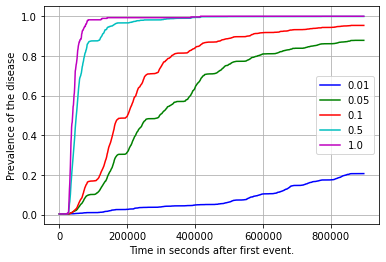

In [13]:
n_it = 10 # number of iterations
infection_probs = [0.01, 0.05, 0.1, 0.5, 1.0] # infection probabilities
id_seed = 0
n_time_bins = 1000

_, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

prevalence_data = []

time_bins = get_time_bins(event_file_path, n_time_bins)

# YOUR CODE HERE
for prob in infection_probs:
    prevalence = []
    print('-----Calculating with Probabiliy={}-----'.format(prob))
    for it in range(n_it):
        print('Iteration {}/{}: Running SI Model with p={}.'.format(it+1, n_it, prob))
        
        inf_times, _ = simulate_si(prob, event_file_path, airport_info_file_path, seed=id_seed)
        prevalence.append(calculate_prevalence(inf_times, time_bins))
    prevalence_data.append(np.mean(prevalence, axis=0))
    print('------------------DONE!------------------')
        
#TODO: Calculate the prevalence for each infection probability
# Hints:

# Repeate simulate_si n_it times for each probability. At each iteration, calculate the prevalence and average
# over iterations.

# For calculating the average, divide the whole time span (from the first departure time to the last arrival) into 
# equal-sized steps using the get_time_bins function you implemented above. You want to use same time steps for 
# all infection probabilities (these will define the x axis of the visualization).

# For the prevalence calculations, use calculate_prevalence defined above.

# For the next step (visualization), you need a list (or np.array) called prevalence_data
# that contains the prevalence as a function of time (either list or np.array) for each infection probability.
# Each row of this array corresponds to an infection probability, and the number of columns should equal to
# n_time_bins.

prevalence_data = np.array(prevalence_data)

colors = ['b','g','r','c','m']
labels = [str(p) for p in infection_probs]
plot_prevalence(prevalence_data, time_bins, colors, labels)

## Task 3: Effect of seed node selection on spreading speed

Next, we will investigate how the selection of the initially infected seed node affects the spreading
speed. To this end, use nodes with node-ids [0, 4, 41, 100, 200] (ABE, ATL, ACN, HSV, DBQ) as seeds
and p = 0.1, and run the simulation 10 times for each seed node. Then, plot the average
prevalence of the disease separately for each seed node as a function of time (recycling
your code for Task 2).

----Calculating with Seed 0----
Iteration 1/10: Running SI Model with seed=0, p=0.1.
Iteration 2/10: Running SI Model with seed=0, p=0.1.
Iteration 3/10: Running SI Model with seed=0, p=0.1.
Iteration 4/10: Running SI Model with seed=0, p=0.1.
Iteration 5/10: Running SI Model with seed=0, p=0.1.
Iteration 6/10: Running SI Model with seed=0, p=0.1.
Iteration 7/10: Running SI Model with seed=0, p=0.1.
Iteration 8/10: Running SI Model with seed=0, p=0.1.
Iteration 9/10: Running SI Model with seed=0, p=0.1.
Iteration 10/10: Running SI Model with seed=0, p=0.1.
----DONE!----
----Calculating with Seed 4----
Iteration 1/10: Running SI Model with seed=4, p=0.1.
Iteration 2/10: Running SI Model with seed=4, p=0.1.
Iteration 3/10: Running SI Model with seed=4, p=0.1.
Iteration 4/10: Running SI Model with seed=4, p=0.1.
Iteration 5/10: Running SI Model with seed=4, p=0.1.
Iteration 6/10: Running SI Model with seed=4, p=0.1.
Iteration 7/10: Running SI Model with seed=4, p=0.1.
Iteration 8/10: Runn

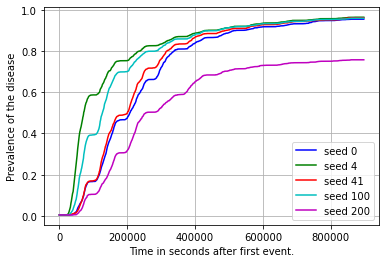

In [14]:
n_it = 10
p = 0.1
seed_nodes = [0, 4, 41, 100, 200]
n_time_bins = 1000

_, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

prevalence_data = []

time_bins = get_time_bins(event_file_path, n_time_bins)

# YOUR CODE HERE
for seed_node in seed_nodes:
    prevalence = []
    print('----Calculating with Seed {}----'.format(seed_node))
    for it in range(n_it):
        print('Iteration {}/{}: Running SI Model with seed={}, p={}.'.format(it+1, n_it, seed_node, p))
        
        inf_times, _ = simulate_si(p, event_file_path, airport_info_file_path, seed=seed_node)
        prevalence.append(calculate_prevalence(inf_times, time_bins))
    prevalence_data.append(np.mean(prevalence, axis=0))
    print('----DONE!----')
#TODO: Calculate the prevalence for each seed node
#Hints: 

# You can re-use your code from task 2; just loop over seed nodes instead of infection probabilities.

# For the next step (visualization), you need a list (or np.array) called prevalence_data
# that contains the prevalence as a function of time (either list or np.array) for each seed node.
# Each row of this array corresponds to a seed node, and the number of columns should equal to
# n_time_bins.

prevalence_data = np.array(prevalence_data)

colors = ['b','g','r','c','m']
labels = ['seed ' + str(seed) for seed in seed_nodes]
plot_prevalence(prevalence_data, time_bins, colors, labels)

## Task 4: Where to hide?

Now, consider that you’d like to be as safe from the epidemic as possible. How should you select
your refuge? To answer this question, run your SI model 50 times with _p_ = 0.5 using different
random nodes as seeds and record the median infection times for each node. Create scatter plots showing the median infection time of each node as a function of the following nodal network measures:

i) unweighted clustering coefficient _c_ \
ii) degree _k_ \
iii) strength _s_ \
iv) unweighted betweenness centrality

Then, use the Spearman rank-correlation coefficient for finding out which of the measures is the best predictor for the infection times.

In this task, you can use the pre-built static network (`aggregated_US_air_traffic_network_undir.edg`)
to compute the various centrality measures using the ready-made NetworkX functions. Function `dic_to_vec` is given to make it easier to handle the network properties.

In [15]:
def dict_to_vec(d):
    """
    Transforms a dictionary (e.g. a dictionary of network properties 
    returned by some networkX function) or a networkX DegreeView object
    to a list sorted in the order of dictionary keys.
    
    Parameters:
    -----------
    d : dictionary or networkX DegreeView object
    
    Returns:
    --------
    vec : list
        list of d.values() sorted by d.keys()
    """
    vec = []
    if isinstance(d, dict):
        for key in sorted(d.keys()):
            vec.append(d[key])
    elif isinstance(d, nx.classes.reportviews.DegreeView):
        nodes = sorted([d1[0] for d1 in d])
        for node in nodes:
            vec.append(d[node])
    return vec

 Iteration 1/50: Running SI Model with seed=220 and p=0.5.
 Iteration 2/50: Running SI Model with seed=184 and p=0.5.
 Iteration 3/50: Running SI Model with seed=72 and p=0.5.
 Iteration 4/50: Running SI Model with seed=100 and p=0.5.
 Iteration 5/50: Running SI Model with seed=207 and p=0.5.
 Iteration 6/50: Running SI Model with seed=68 and p=0.5.
 Iteration 7/50: Running SI Model with seed=276 and p=0.5.
 Iteration 8/50: Running SI Model with seed=7 and p=0.5.
 Iteration 9/50: Running SI Model with seed=211 and p=0.5.
 Iteration 10/50: Running SI Model with seed=62 and p=0.5.
 Iteration 11/50: Running SI Model with seed=231 and p=0.5.
 Iteration 12/50: Running SI Model with seed=26 and p=0.5.
 Iteration 13/50: Running SI Model with seed=151 and p=0.5.
 Iteration 14/50: Running SI Model with seed=244 and p=0.5.
 Iteration 15/50: Running SI Model with seed=126 and p=0.5.
 Iteration 16/50: Running SI Model with seed=76 and p=0.5.
 Iteration 17/50: Running SI Model with seed=243 and p=0

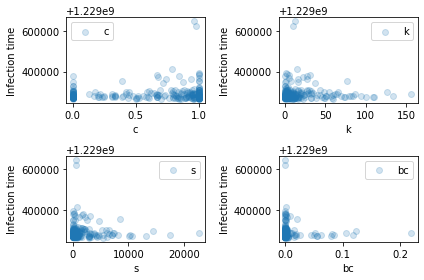

In [16]:
p = 0.5
n_seeds = 50

net, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

inf_time_data = []

median_inf_times = []
props = []

# YOUR CODE HERE
n_airports = len(id_data)
seeds = np.random.choice(n_airports, n_seeds, False)
for it, seed in enumerate(seeds):
    print(' Iteration {}/{}: Running SI Model with seed={} and p={}.'.format(it+1, n_seeds, seed, p))
    inf_times, _ = simulate_si(p, event_file_path, airport_info_file_path, seed=seed)
    inf_times = np.array(inf_times, dtype=np.float)
    inf_times[inf_times==np.float('inf')]=np.nan
    inf_time_data.append(inf_times)
median_inf_times = np.nanmedian(inf_time_data, axis=0)
    
props.append(dict_to_vec(nx.clustering(net)))
props.append(dict_to_vec(net.degree()))
props.append(dict_to_vec(net.degree(weight='weight')))
props.append(dict_to_vec(nx.betweenness_centrality(net)))

#TODO: Run si_simulator for 50 random seeds to obtain the median infection time; obtain the listed 
# network properties
#Hints: 

# If a node never gets infected, its infection time remains Inf. You want to ignore these infection 
# times while calculating the median. To this end, you can first replace Infs with nans and then use np.nanmedian.

# Feel free to use any networkX functions for obtaining the network properties. These functions return
# either dictionaries or networkX DegreeView objects; you can use the dict_to_vec function given above
# to transform these into ordered lists.

# For the next step (visualization), you need a list (or n.array) of median infection times 
# (median_infection_times) and a list where each element is a list containing the values of one network property
# for all nodes. These lists need to be in the same order.

prop_names = ["c","k", "s", "bc"]

plot_scatters_in_subplots(props, median_inf_times, labels=prop_names)

rs = []

# YOUR CODE HERE
for prop in props:
    rs.append(scipy.stats.spearmanr(prop, median_inf_times).correlation)
#TODO: calculate the Spearman rank correlation between each network property and median infection times 
#Hint: scipy.stats.spearmanr

for prop_name, r in zip(prop_names, rs):
    print('Spearman r between median infection time and ' + prop_name + ': ' + str(r))

## Task 5: Shutting down airports

Now take the role of a government official considering shutting down airports to prevent the
disease from spreading to the whole country. In our simulations, the shutting down of airports
corresponds to immunization: an airport that has been shut down can not become infected at
any point of the simulation.

One immunization strategy suggested for use in social networks is to pick a random node from
the network and immunize a random neighbour of this node. Your task is now to compare
this strategy against five other immunization strategies: the immunization of random nodes
and the immunization of nodes that possess the largest values of the four measures of centrality/importance that we used in task 4. 

Using each of the immunization strategies, immunize 10 nodes. Then, plot the average prevalence as a function of time for each immunization strategy. Use _p_ = 0.5 and average the prevalence over 20 runs of the model for each immunization strategy, each with a different seed node (120 simulations in total). 

To reduce the variance due to the selection of seed nodes, use same seed nodes for investigating
all immunization strategies. To this end, first select your immunized nodes, and then select 20
random seed nodes such that none of them belongs to the group of immunized nodes in any of
the 6 different strategies.

<ipython-input-17-41964b31e418>:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node in v:
<ipython-input-9-9c4d1117f268>:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (infection_times[destinition] > e_time) and (np.random.rand() <= infection_prob) and destinition not in immunized_nodes:


----Starting Strategy c----
Iteration 1/20: Strategy c:, seed_node: 110.
Iteration 2/20: Strategy c:, seed_node: 49.
Iteration 3/20: Strategy c:, seed_node: 135.
Iteration 4/20: Strategy c:, seed_node: 200.
Iteration 5/20: Strategy c:, seed_node: 50.
Iteration 6/20: Strategy c:, seed_node: 27.
Iteration 7/20: Strategy c:, seed_node: 172.
Iteration 8/20: Strategy c:, seed_node: 106.
Iteration 9/20: Strategy c:, seed_node: 109.
Iteration 10/20: Strategy c:, seed_node: 226.
Iteration 11/20: Strategy c:, seed_node: 1.
Iteration 12/20: Strategy c:, seed_node: 103.
Iteration 13/20: Strategy c:, seed_node: 61.
Iteration 14/20: Strategy c:, seed_node: 257.
Iteration 15/20: Strategy c:, seed_node: 132.
Iteration 16/20: Strategy c:, seed_node: 50.
Iteration 17/20: Strategy c:, seed_node: 261.
Iteration 18/20: Strategy c:, seed_node: 235.
Iteration 19/20: Strategy c:, seed_node: 161.
Iteration 20/20: Strategy c:, seed_node: 190.
----DONE!----
----Starting Strategy k----
Iteration 1/20: Strategy k

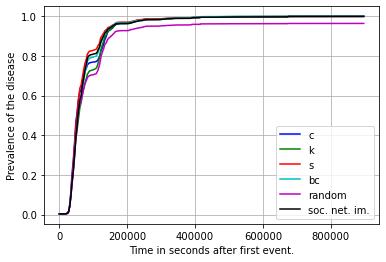

In [17]:
p = 0.5
n_seeds = 20
n_immunized = 10
n_time_bins = 1000

strategy_names = ["c","k","s","bc","random","soc. net. im."]

net, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

prevalence_data = []

time_bins = get_time_bins(event_file_path, n_time_bins)

# YOUR CODE HERE
n_airports = len(id_data)
immunized_nodes = {}

def nodes(measure):
    return np.array(sorted(measure.keys(), key=lambda key: measure[key], reverse=True)[:n_immunized])

def random_neighbour():
    nodes = set()
    while len(nodes) < n_immunized:
        random_node = str(np.random.choice(n_airports))
        random_neighbour = np.random.choice(list(net.neighbors(random_node)))
        nodes.add(random_neighbour)
    return np.array(nodes)

immunized_nodes['c'] = nodes(nx.clustering(net))
immunized_nodes['k'] = nodes(dict(net.degree()))
immunized_nodes['s'] = nodes(dict(net.degree(weight='weight')))
immunized_nodes['bc'] = nodes(nx.betweenness_centrality(net))
immunized_nodes['random'] = np.random.choice(n_airports, n_immunized, replace=False)
immunized_nodes['soc. net. im.'] = random_neighbour()

def in_immune_nodes(node):
    for k,v in immunized_nodes.items():
        if node in v:
            return True
    return False

seed_nodes = []
while len(seed_nodes) < n_seeds:
    node = np.random.choice(n_airports)
    if not in_immune_nodes(node):
        seed_nodes.append(node)

for strategy in strategy_names:
    prevalence = []
    print('----Starting Strategy {}----'.format(strategy))
    for it, seed_node in enumerate(seed_nodes):
        print('Iteration {}/{}: Strategy {}:, seed_node: {}.'.format(it+1, n_seeds, strategy, seed_node))
        inf_times, _ = simulate_si(p, 
                                   event_file_path, 
                                   airport_info_file_path, 
                                   immunized_nodes=immunized_nodes[strategy], 
                                   seed=seed_node)
        prevalence.append(calculate_prevalence(inf_times, time_bins))
    prevalence_data.append(np.mean(prevalence, axis=0))
    print('----DONE!----')

#TODO: Calculate the prevalence for each immunization strategy
#Hints:

# Modify your implementation of simulate_si from task 1 to allow node immunization. To this end, add a list 
# (or set) of immunized nodes as an optional input, with an empty list (or set) as the default value. Then, 
# when about to infect a node, check if the node is in the list/set, and if, do not infect.

# Before running simulate_si, define the immunized nodes for each of the 6 strategies and the seed nodes. You want
# to use the same random seed nodes for each immunization strategy. While selecting the seeds, ensure that they
# are not among the immunized nodes.

# You can re-use your code from task 2, this time looping over immunization strategies.

# For the next step (visualization), you need a list (or np.array) called prevalence_data
# that contains the prevalence as a function of time (either list or np.array) for each seed node.
# Each row of this array corresponds to a seed node, and the number of columns should equal to
# n_time_bins.

prevalence = np.array(prevalence_data)

colors = ['b','g','r','c','m','k']
plot_prevalence(prevalence_data, time_bins, colors, labels=strategy_names)

## Task 6: Disease-transmitting links

So far we have only analyzed the importance of network nodes — next, we will discuss the role of
links. We will do this by recording the number of times each link transmits the disease to
another node. 

So, adapt your code for recording the (undirected) static links which are used to
transmit the disease. You can do this e.g. by storing for each node from which other node it obtained
the infection.

Run 20 simulations using random nodes as seeds and _p_ = 0.5. For each simulation, record which links are used to
infect yet uninfected airports (either by first infection-carrying flights arriving to susceptible airports or by infecting flights arriving before the already recorded infection time). After running the simulations, compute the fraction of times that each link is used for infecting the disease (_f<sub>ij</sub>_ ). 

Then, use the function `plot_network_USA which` provided above to visualize the network on top of the US map (see the example code given in the function). Adjust the width of the links according to the fractions _f<sub>ij</sub>_ to better see the overall structure. Compare your visualization with the maximal spanning
tree of the network.

Then, create scatter plots showing _f<sub>ij</sub>_ as a function of the following link properties:

i) link weight _w<sub>ij</sub>_ \
ii) unweighted link betweenness centrality _eb<sub>ij</sub>_ (`edge_betweenness_centrality` in NetworkX)

Compute also the Spearman correlation coefficients between _f<sub>ij</sub>_ and the two link-wise
measures.

 Iteration 1/20: Seed=261.
 Iteration 2/20: Seed=171.
 Iteration 3/20: Seed=236.
 Iteration 4/20: Seed=137.
 Iteration 5/20: Seed=263.
 Iteration 6/20: Seed=15.
 Iteration 7/20: Seed=204.
 Iteration 8/20: Seed=45.
 Iteration 9/20: Seed=150.
 Iteration 10/20: Seed=15.
 Iteration 11/20: Seed=89.
 Iteration 12/20: Seed=273.
 Iteration 13/20: Seed=267.
 Iteration 14/20: Seed=239.
 Iteration 15/20: Seed=196.
 Iteration 16/20: Seed=26.
 Iteration 17/20: Seed=91.
 Iteration 18/20: Seed=166.
 Iteration 19/20: Seed=24.
 Iteration 20/20: Seed=86.
Spearman r between median infection time and weight: SpearmanrResult(correlation=0.37052365242952695, pvalue=6.029824570793584e-69)
Spearman r between median infection time and edge betweenness: SpearmanrResult(correlation=-0.0121752556773516, pvalue=0.578189413891484)


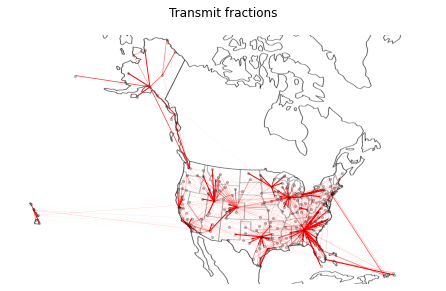

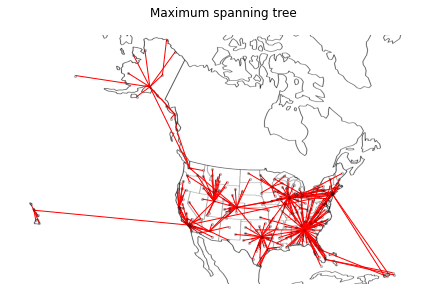

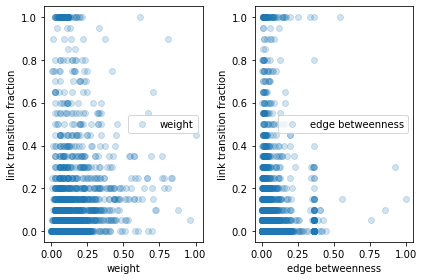

In [18]:
p = 0.5
n_seeds = 20

net, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

# YOUR CODE HERE
n_airports = len(id_data)
seed_nodes = np.random.choice(n_airports, n_seeds)

links = list(net.edges())
link_trans_fracs = [0 for _ in links]
for it, seed_node in enumerate(seed_nodes):
    print(" Iteration {}/{}: Seed={}.".format(it+1, n_seeds, seed_node))
    inf_time, _, transmit = simulate_si(p, event_file_path, airport_info_file_path, seed=seed_node, return_trans_nodes=True)
    
    for v, w in enumerate(transmit):
        if (str(v), str(w)) in links:
            link_trans_fracs[links.index((str(v), str(w)))] += 1
        if (str(w), str(v)) in links:
            link_trans_fracs[links.index((str(w), str(v)))] += 1

link_trans_fracs = [l/20.0 for l in link_trans_fracs]
mst = nx.maximum_spanning_tree(net)
#TODO: Calculate the fraction of simulations each link carried the disease and construct the maximal spanning
# tree of the network.

#Hints:

# Modify your implementation of simulate_si from task 1 to record which links carried the disease.

# For running the simulations, you can again re-use your code from task 2.

# Feel free to use the networkX function for calculating the maximum spanning tree.

# For the next step (visualization), you need a list of links of the network (called links), a list of disease
# transmission fractions per link (called link_trans_fracs), and the maximum spanning tree (called mst).

# coordinates of nodes are needed for visualization
id_data = np.genfromtxt(airport_info_file_path, delimiter=',', dtype=None, names=True, encoding=None)
xycoords = {}
for row in id_data:
    xycoords[str(row['id'])] = (row['xcoordviz'], row['ycoordviz'])

fig, ax  = plot_network_usa(net, xycoords, background_image_file_path, edges=links, linewidths=link_trans_fracs)
fig.suptitle('Transmit fractions')

fig, ax = plot_network_usa(net, xycoords, background_image_file_path, edges=mst.edges())
fig.suptitle('Maximum spanning tree')

# YOUR CODE HERE
weights = [0 for _ in links]
for i, (w, v) in enumerate(links):
    weights[i] = net.get_edge_data(w, v)['weight']
    
weights = np.array(weights)
weights = weights/max(weights)

ebs = dict_to_vec(nx.edge_betweenness_centrality(net))
ebs = np.array(ebs)
ebs = ebs/max(ebs)
#TODO: Obtain the weight and edge betweenness of each link.
#Hints: 

# nx.edge_betweenness_centrality

# For visualization purposes, you may want to normalize weights and edge betweenness centralities by their
# maximum values.

# For the next step (visualization), you need lists or np.arrays of link weights (called weights) and 
# edge betweenness centralities (called ebs).

props = [weights, ebs]
prop_names = ['weight', 'edge betweenness']

plot_scatters_in_subplots(props, link_trans_fracs, labels=prop_names, n_columns=2, \
                          y_label='link transition fraction', x_labels=[])

rs = []

# YOUR CODE HERE
for prop in props:
    rs.append(scipy.stats.spearmanr(prop, link_trans_fracs))
#TODO: Calculate the Spearman rank correlation between the link-wise properties and link transition fraction

for prop_name, r in zip(prop_names, rs):
    print('Spearman r between median infection time and ' + prop_name + ': ' + str(r))